<a href="https://colab.research.google.com/github/junghoon-1999/Formula1-Strategy/blob/main/Model_Fitting-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import optuna

In [7]:
# Import data and initialize drivers to evaluate and run the model
total_tele_bah = pd.read_csv('/content/drive/MyDrive/tot_dat_bah.csv')
total_tele_bah.drop(columns = ['Unnamed: 0'], inplace = True)
total_tele = total_tele_bah
drivers = ['VER','GAS','PER','ALO','LEC','STR','SAR','MAG','DEV','TSU','ALB','ZHO',
 'HUL','OCO','NOR','HAM','SAI','RUS','BOT','PIA']

In [11]:
# Create sequences and labels for the data
seq = []
lab = []
target = []
remainder = []
start_seq = 0
end_seq = 0
drivers_distance = [i+'_Distance' for i in drivers]
distances = total_tele[drivers_distance]

# For every 50 sequences we will predict the next 100 sequences
for i in range(150, len(total_tele), 150):
    end_seq = i

    # Append 50 items to the sequence list and convert them to numpy
    seq.append(total_tele.loc[start_seq:end_seq-100-1].to_numpy())

    # Append the last item of every subsequent 50 items to the target list and convert them to numpy
    target1 = distances.loc[end_seq-100:end_seq-50-1].to_numpy()
    target2 = distances.loc[end_seq-50:end_seq-1].to_numpy()
    temp = np.concatenate((target1, target2), axis = 1)
    target.append(temp)
    start_seq = i

remainder.append(total_tele.loc[len(total_tele) - len(total_tele)%50+1: len(total_tele)].to_numpy())
seq = torch.stack([torch.tensor(s.astype(float), dtype=torch.float) for s in seq])
target = torch.stack([torch.tensor(s.astype(float), dtype=torch.float) for s in target])

In [12]:
# Create training and test set
# Shuffling the sequence and target dataset
np.random.seed(12)
shuffled_indices = np.random.permutation(len(seq))
seq = seq[shuffled_indices]
target = target[shuffled_indices]

# Define testing dataset and training dataset
train_size = int(len(seq)*0.8)
val_size = int(len(seq)*0.9)

train_seq = seq[:train_size]
train_target = target[:train_size]

val_seq = seq[train_size:val_size]
val_target = target[train_size:val_size]

test_seq = seq[val_size:]
test_target = target[val_size:]


In [13]:
from torch.utils.data import DataLoader

bs = 16

# Load and preprocess data for deep learning models
input_dataloader = DataLoader(train_seq, batch_size=bs)
target_dataloader = DataLoader(train_target, batch_size=bs)

val_input_dataloader = DataLoader(val_seq, batch_size=bs)
val_target_dataloader = DataLoader(val_target, batch_size=bs)

test_input_dataloader = DataLoader(test_seq, batch_size=bs)
test_target_dataloader = DataLoader(test_target, batch_size=bs)

# 3. Model set up

In [14]:
class FFN(torch.nn.Module):
    def __init__(self, hidden_dim):
        super(FFN, self).__init__()
        self.gelu = nn.GELU()
        self.ffn = nn.Linear(hidden_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        identity = x
        x = self.ffn(x)
        x = self.gelu(x) + identity
        x = self.norm(x)
        return x

class SelfAttnLayer(torch.nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super(SelfAttnLayer, self).__init__()
        self.gelu = nn.GELU()
        self.mha = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        identity = x
        x, _ = self.mha(x, x, x)
        x = self.gelu(x) + identity
        x = self.norm(x)
        return x


class Model(torch.nn.Module):

    def __init__(self, hidden_dim, num_heads, n_layers, rate):
        super(Model, self).__init__()
        self.linear_in = nn.Linear(927, hidden_dim)
        self.gelu = nn.GELU()

        module_lst = []
        for _ in range(n_layers):
            # module_lst.append(nn.LayerNorm(hidden_dim))
            module_lst.append(SelfAttnLayer(hidden_dim, num_heads))
            module_lst.append(FFN(hidden_dim))
            module_lst.append(nn.Dropout(p = rate))

        self.module_lst = nn.ModuleList(module_lst)
        # self.sl1 = SelfAttnLayer(hidden_dim, num_heads)
        # self.ffn1 = FFN(hidden_dim)
        # self.sl2 = SelfAttnLayer(hidden_dim, num_heads)
        # self.ffn2 = FFN(hidden_dim)
        # self.norm1 = nn.LayerNorm(hidden_dim)
        # self.norm2 = nn.LayerNorm(hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.out_head = nn.Linear(hidden_dim, 40)
        # self.dropout = nn.Dropout(p = 0.075) # 0.1, 0.2

    def forward(self, x):
        x = self.linear_in(x)
        x = self.gelu(x)
        for module in self.module_lst:
            x = module(x)
        # x = self.sl1(x)
        # x = self.ffn1(x)
        # x = self.dropout(x)
        # x = self.sl2(x)
        # x = self.ffn2(x)
        x = self.out_head(x)
        return x


# 4. Model Training

# 4-1. Defining the MAE

The model returns error values of near 1.0 when estimating values near the starting points. This happens when the vehicles is either behind or right in front of the starting point and the model predicts the other side. Hence we will use a custom MAE that is capable of correcting error values for these predictions

In [15]:
import torch
import torch.nn as nn

class CustomMAELoss(nn.Module):
    def __init__(self):
        super(CustomMAELoss, self).__init__()

    def forward(self, output, target):
        loss = torch.abs(output - target)

        high_loss_indices = torch.nonzero(loss > 4800 / 5412, as_tuple=True)

        if len(high_loss_indices[0]) > 0:
            loss[high_loss_indices] = 1 - loss[high_loss_indices]

        return torch.mean(torch.abs(loss))

## 4-2. Hyperparameter Tuning

In [ ]:
def objective(trial):

  # Define grid space
  n_layers = trial.suggest_int("n_layers", 1, 8)
  hidden_dim = trial.suggest_int("hidden_dim", 256, 1024, step = 128)
  num_heads = trial.suggest_categorical("num_heads",[2, 4, 8])
  rate = trial.suggest_categorical('rate', [0.1, 0.75, 0.5])
  lr = trial.suggest_float("lr", 0.0001, 0.001, step = 0.0002)

  # Initialize for tuning
  device = torch.device('cuda')
  model = Model(hidden_dim, num_heads, n_layers, rate).to(device)
  model = model.float()
  loss = CustomMAELoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr = lr)

  for epoch in range(500):


    model.train()
    loss_val = 0

    for s, t in zip(input_dataloader, target_dataloader):
      s = s.to(device)
      t = t.to(device)
      optimizer.zero_grad()
      output = model(s)
      mae_loss = loss(output, t)
      mae_loss.backward()
      optimizer.step()

    model.eval()
    val_loss_val = 0
    for s, t in zip(val_input_dataloader, val_target_dataloader):
        s = s.to(device)
        t = t.to(device)
        logits = model(s)
        mae_loss = loss(logits, t)
        val_loss_val += (mae_loss.item())

    val_avg_loss = val_loss_val / len(val_input_dataloader)

    trial.report(val_avg_loss, epoch)

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

  return val_avg_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print('Best trial:')
trial = study.best_trial

print("value: {:.4f}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))


Optuna suggested the following parameters

    - n_layers: 3
    - hidden_dim: 896
    - num_heads: 2
    - rate: 0.1
    - lr: 0.0005

## 4-3. Training

In [139]:
# Initialize model and set up
device = torch.device('cuda')
model = Model(896, 2, 3, 0.1).to(device)
loss = CustomMAELoss()
opt = torch.optim.AdamW(model.parameters(), lr = 0.0005) # 0.01, 0.005

losses = []
val_losses = []

outputs = []
tot = []
min_val_loss = 1000000000000
for epoch in range(600):
    model.train()
    loss_val = 0
    for s, t in zip(input_dataloader, target_dataloader):
        s = s.to(device)
        t = t.to(device)
        opt.zero_grad()
        logits = model(s)
        mae_loss = loss(logits, t)
        mae_loss.backward()
        opt.step()
        loss_val += (mae_loss.item())
    avg_loss = loss_val / len(input_dataloader)
    losses.append(avg_loss)

    model.eval()
    val_loss_val = 0
    for s, t in zip(val_input_dataloader, val_target_dataloader):
        s = s.to(device)
        t = t.to(device)
        logits = model(s)
        mae_loss = loss(logits, t)
        val_loss_val += (mae_loss.item())

    val_avg_loss = val_loss_val / len(val_input_dataloader)
    if val_avg_loss < min_val_loss:
        min_val_loss = val_avg_loss
        best_model = model.state_dict()

    val_losses.append(val_avg_loss)
    print(f"Epoch {epoch}, {avg_loss= }, {val_avg_loss= }")


Epoch 0, avg_loss= 0.3151422341664632, val_avg_loss= 0.21138624101877213
Epoch 1, avg_loss= 0.22957689960797628, val_avg_loss= 0.15488621592521667
Epoch 2, avg_loss= 0.20118610660235087, val_avg_loss= 0.13045384734869003
Epoch 3, avg_loss= 0.18174990316232045, val_avg_loss= 0.11554669216275215
Epoch 4, avg_loss= 0.16739520231882732, val_avg_loss= 0.11579496040940285
Epoch 5, avg_loss= 0.15389951964219412, val_avg_loss= 0.10371122136712074
Epoch 6, avg_loss= 0.1391499976317088, val_avg_loss= 0.1031917966902256
Epoch 7, avg_loss= 0.12540053178866703, val_avg_loss= 0.10047516226768494
Epoch 8, avg_loss= 0.11612383226553599, val_avg_loss= 0.11469680070877075
Epoch 9, avg_loss= 0.10785571485757828, val_avg_loss= 0.09876575693488121
Epoch 10, avg_loss= 0.10062711586554846, val_avg_loss= 0.09838973358273506
Epoch 11, avg_loss= 0.09286936918894449, val_avg_loss= 0.10115434601902962
Epoch 12, avg_loss= 0.08925018906593322, val_avg_loss= 0.08875895291566849
Epoch 13, avg_loss= 0.0840590298175811

## 4-2. Testing

In [140]:
model.load_state_dict(best_model)
model.eval()
test_loss_val = 0
output = []
for s, t in zip(test_input_dataloader, test_target_dataloader):
    s = s.to(device)
    t = t.to(device)
    logits = model(s)
    output.append(logits)
    mse_loss = loss(logits, t)

    test_loss_val += (mse_loss.item())
test_avg_loss = test_loss_val / len(test_input_dataloader)

In [141]:
# Unscaled loss
test_avg_loss *5412

221.44075655937195

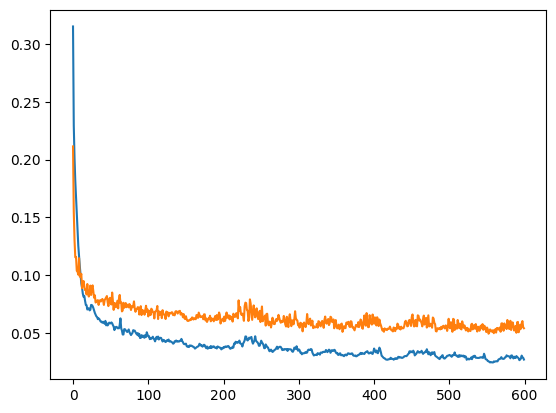

In [281]:
plt.plot(losses)
plt.plot(val_losses)

# 5. Error Analysis

Overall the model behaves well but exhibits massive spikes in error values for certain mini batch of data. This section will uncover the blackbox behind these error values and understand the limitations of this project.

In [ ]:
# Get the output tensor for error analysis
exp_val = torch.vstack((output)).to('cpu')
test_target = test_target.to('cpu')

In [ ]:
dataframes = []
obs_loss = pd.DataFrame(columns = ['Results', 'Drv', 'Iter'])

err = torch.abs(exp_val - test_target)
high_loss_indices = torch.nonzero((err) > 4800 / 5412, as_tuple=True)

if len(high_loss_indices[0]) > 0:
    err[high_loss_indices] = 1 - (err[high_loss_indices])

obs_err = err.detach().numpy()

for j in range(len(obs_err)):
    for i in range(len(drivers)):
        # Concatenate the specified slices from exp_val[j]
        concat_array = np.concatenate((obs_err[j, :, i]*5412, obs_err[j, :, 20+i]*5412), 0)
        df = pd.DataFrame()
        df['Results'] = concat_array
        df['Drv'] = drivers[i]
        df['Iter'] = j
        dataframes.append(df)

# Concatenate all DataFrames horizontally
obs_loss = pd.concat(dataframes, axis=0)

In [144]:
# Calculate the average of 'value' for each 'Drv'
grp_obs_loss = obs_loss.groupby(['Drv', 'Iter'])['Results'].mean().reset_index()

# Rename the columns for clarity
grp_obs_loss.columns = ['Drv', 'Iter',  'AverageValue']

In [145]:
drv_1 = ['VER', 'PER', 'ALO', 'SAI', 'HAM']
drv_2 = ['STR', 'RUS', 'BOT', 'GAS', 'ALB']
drv_3 = ['TSU', 'SAR', 'MAG', 'DEV', 'HUK']
drv_4 = ['ZHO', 'NOR', 'OCO', 'LEC', 'PIA']
drv_5 = ['OCO', 'LEC', 'PIA']

In [146]:
# Create a function that returns the index of the column we are interested in to use for error analysis
def get_col_ind(col_name):
    for i in range(len(total_tele.columns)):
        if total_tele.columns[i] == col_name:
            return i

In [147]:
import plotly.express as px
dat = grp_obs_loss[grp_obs_loss['Drv'].isin(drv_1)]
fig = px.line(dat, x = 'Iter', y = 'AverageValue', color = 'Drv')
fig.show()

We will analysis error values that are above 800.

## 1. Sainz

Predition for Sainz did well overall, however there were significant peaks in the following laps: 15, 29 and 56.

Apart from 29 the laps 15 and 56 had something in common, the predicted values were decreasing at around 0.07 - 0.08. This could be attributed to the fact that drivers who DNFed all failed at around this distance.


## 2. Alonso

Prediction for Alonso was consistent and well overall, however there was a significant peak in error at the 2nd and 19th iteration (15th lap, 48th lap).

The model had issues with jumping from the end of the lap to the start of the lap. This may be attributed to the fact that there are only 57 time stamps where this was occuring.

## 3. Perez

Predictions for Perez was also consistent and well overall. However, significant error values were shown for iteration 8, 15 and 22.

Iteration 8 and 22 had the same reason for its error values as Alonso and Sainz. The Model could not transition from 0.9 to 0.0.

# 4. Verstappen

Predictions for Verstappen had the most volatility in terms of error. Iterations 12, 17, 22 were all due to the model's inability to adapt to the end of the lap and the beginning of the next lap.

Iteration 19's error was however notable, as this was when Perez and Verstappen changed positions this may have been due to a team strategic move something the model cannot capture and was not intended to capture.

# The second group

In [207]:
dat = grp_obs_loss[grp_obs_loss['Drv'].isin(drv_2)]
fig = px.line(dat, x = 'Iter', y = 'AverageValue', color = 'Drv')
fig.show()

The second group prediction worked out a lot better than the first group overall with 4 points of error values above 800. All points occurred mid track and were due to unexplained variances.

# 3. Group 3

In [232]:
dat = grp_obs_loss[grp_obs_loss['Drv'].isin(drv_3)]
fig = px.line(dat, x = 'Iter', y = 'AverageValue', color = 'Drv')
fig.show()

## 1. Magnussen

At the 17th iteration the beginning of the lap it overestimated


## 2. Sargeant

At the 12th iteration which was at the end of the lap it had the same decreasing prediction problem.

## 3. De Vrie

Both De Vrie's error values were due to the variance of the model's predictions.

# 4. Group 4

In [254]:
dat = grp_obs_loss[grp_obs_loss['Drv'].isin(drv_4)]
fig = px.line(dat, x = 'Iter', y = 'AverageValue', color = 'Drv')
fig.show()

## 1. Norris

The 27th iteration (54th lap) was when Norris Pitted his vehicle. The model was not able to capture that information

## 2. Leclerc

Both Leclerc's error values occured when he DNFed.

# 5. The DNF/Lapped group

In [279]:
dat = grp_obs_loss[grp_obs_loss['Drv'].isin(drv_5)]
fig = px.line(dat, x = 'Iter', y = 'AverageValue', color = 'Drv')
fig.show()

Overall the model does seem to be able to predict to some level whether a vehicle is going to DNF or not. With better imputation methods this prediction performance may improve

# Evaluation scores across iterations

## 1. Some iterations performed extremely well as shown below

In [300]:
import plotly.express as px
data = obs_loss[obs_loss['Iter'] == 0]
fig = px.line(data, x = data.index, y = 'Results', color = 'Drv')
fig.show()

# While others did not perform so well

In [301]:
import plotly.express as px
data = obs_loss[obs_loss['Iter'] == 20]
fig = px.line(data, x = data.index, y = 'Results', color = 'Drv')
fig.show()